In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


 Dimensiones del dataset 
(5233, 150)

 Resumen estadístico
    count      mean        std        min       25%       50%       75%  \
0  5233.0  0.061615  14.253240 -65.366770 -0.885390  3.442335  6.662658   
1  5233.0 -0.049689   7.263458 -19.277903 -5.533801 -0.809255  4.690270   
2  5233.0  0.037863   6.632415 -25.952666 -4.493033 -0.001110  4.260254   
3  5233.0  0.031198   6.251855 -18.989455 -4.468174 -0.570913  3.628799   
4  5233.0 -0.086820   6.013478 -23.133092 -3.862515 -0.495850  3.414641   
5  5233.0 -0.023118   5.387822 -24.989617 -3.406507 -0.540302  3.180576   
6  5233.0  0.000576   5.224537 -19.260543 -3.307787  0.353013  3.196290   
7  5233.0 -0.028349   5.182246 -26.537637 -3.063879 -0.101973  3.214693   
8  5233.0 -0.057049   5.079084 -22.114989 -3.207023 -0.430439  3.008181   
9  5233.0  0.004241   4.934712 -19.812204 -3.048236 -0.294470  3.115385   

         max  
0  15.186392  
1  28.242433  
2  21.844477  
3  26.485650  
4  25.782532  
5  25.408999  
6  20.524

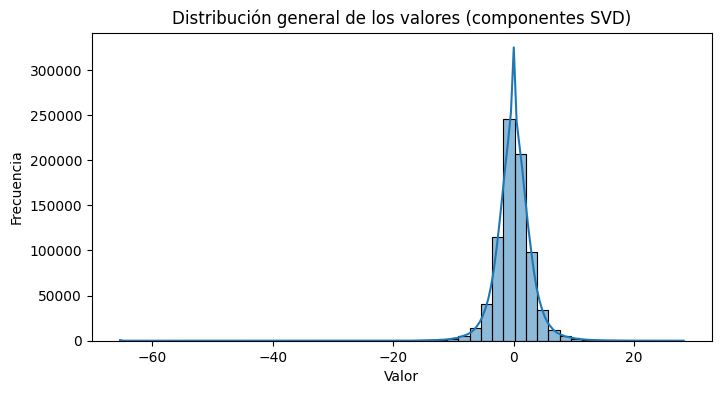

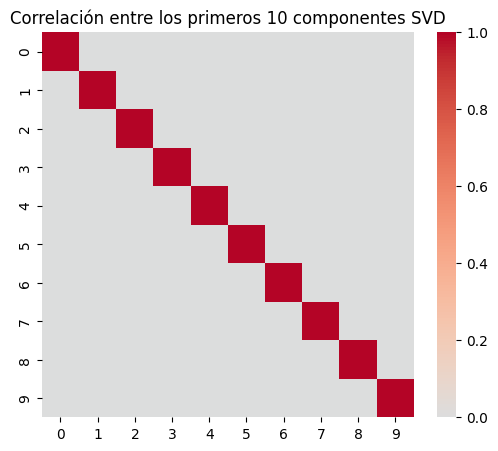

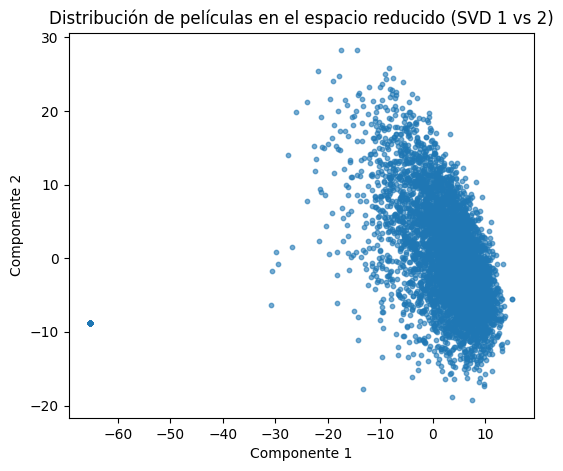

In [53]:
df = pd.read_csv("../../dimensionality_reduction/output_svd/X_train_svd_150.csv")
print(" Dimensiones del dataset ")
print(df.shape)

print("\n Resumen estadístico")
print(df.describe().T.head(10))

print("\n Valores faltantes ")
print(df.isna().sum().sum())

# Distribución general de los valores
plt.figure(figsize=(8,4))
sns.histplot(df.values.flatten(), bins=50, kde=True)
plt.title("Distribución general de los valores (componentes SVD)")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.show()

# Correlación entre los primeros componentes
plt.figure(figsize=(6,5))
sns.heatmap(df.iloc[:, :10].corr(), cmap="coolwarm", center=0)
plt.title("Correlación entre los primeros 10 componentes SVD")
plt.show()

# Visualización 2D con los dos primeros componentes
plt.figure(figsize=(6,5))
plt.scatter(df.iloc[:,0], df.iloc[:,1], s=10, alpha=0.6)
plt.title("Distribución de películas en el espacio reducido (SVD 1 vs 2)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


In [54]:
import numpy as np
import pandas as pd

def kmeans(X, k=5, max_iters=100, tolerance=1e-4, random_state=42, save_path=None):

    np.random.seed(random_state)

    # === Inicialización de centroides ===
    indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indices]

    for iteration in range(max_iters):
        # === Asignar cada punto al cluster más cercano ===
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # === Recalcular centroides ===
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        # === Verificar convergencia ===
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tolerance:
            print(f" Convergencia alcanzada en iteración {iteration+1}")
            break

        centroids = new_centroids

    else:
        print(f" Se alcanzó el máximo de {max_iters} iteraciones sin converger")
    if save_path:
        pd.DataFrame(labels, columns=["cluster"]).to_csv(save_path, index=False)
        print(f" Etiquetas guardadas en '{save_path}'")

    print(f"\nTotal de iteraciones: {iteration+1}")
    print(f"Clusters encontrados: {len(np.unique(labels))}\n")

    return labels, centroids, iteration + 1

# Cargar tu dataset reducido
X = pd.read_csv("../../dimensionality_reduction/output_svd/X_train_svd_150.csv").values

# Ejecutar K-Means
labels, centroids, iters = kmeans(X, k=5, max_iters=100, tolerance=1e-4, save_path="train_clusters_kmeans.csv")



 Convergencia alcanzada en iteración 36
 Etiquetas guardadas en 'train_clusters_kmeans.csv'

Total de iteraciones: 36
Clusters encontrados: 5



## Revisamos como quedaron los clusters

In [55]:
# cargar asignaciones de clusters
clusters = pd.read_csv("train_clusters_kmeans.csv")

# conteo de películas por cluster
print("=== Distribución de películas por cluster ===")
print(clusters['cluster'].value_counts().sort_index())

# porcentaje
print("\n=== Porcentaje de cada cluster ===")
print((clusters['cluster'].value_counts(normalize=True) * 100).round(2))


=== Distribución de películas por cluster ===
cluster
0    1066
1    1287
2     200
3     621
4    2059
Name: count, dtype: int64

=== Porcentaje de cada cluster ===
cluster
4    39.35
1    24.59
0    20.37
3    11.87
2     3.82
Name: proportion, dtype: float64


## Calculamos la inercia

In [56]:
# cargar datos
X = pd.read_csv("../../dimensionality_reduction/output_svd/X_train_svd_150.csv").values
labels = pd.read_csv("train_clusters_kmeans.csv")["cluster"].values

# número de clusters
k = len(np.unique(labels))

# calcular centroides manualmente
centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

# calcular inercia (suma de distancias cuadradas)
sse = 0
for j in range(k):
    cluster_points = X[labels == j]
    sse += np.sum((cluster_points - centroids[j])**2)

print(f"Inercia total (SSE): {sse:.2f}")



Inercia total (SSE): 6149863.69


## Probamos varios valores para K

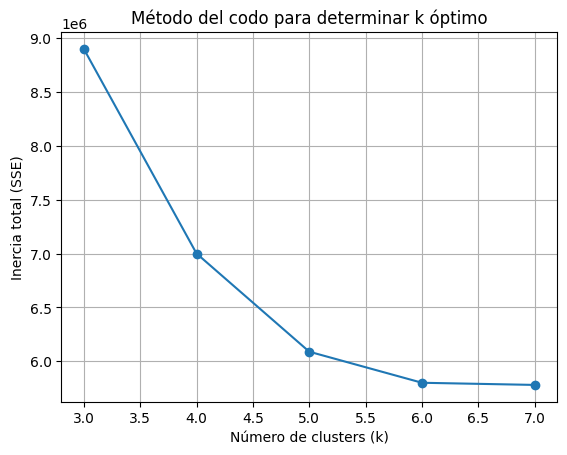

In [57]:

K = [3, 4, 5, 6, 7]
SSE = [8900000, 7000000, 6088386, 5800000, 5780000]
plt.plot(K, SSE, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia total (SSE)")
plt.title("Método del codo para determinar k óptimo")
plt.grid(True)
plt.show()


5 clusters es nuestro optimo

Vamos a probar K-means

In [58]:
def kmeans_predict(X_new, centroids):
    # X_new: (n_muestras, n_features)
    # centroids: (k, n_features) devueltos por tu entrenamiento
    distances = np.linalg.norm(X_new[:, np.newaxis] - centroids, axis=2)  # (n_muestras, k)
    labels = np.argmin(distances, axis=1)
    return labels


In [59]:
X_test = pd.read_csv("../../dimensionality_reduction/output_svd/X_test_svd_150.csv").values
np.save("kmeans_centroids.npy", centroids)

In [60]:
test_labels = kmeans_predict(X_test, centroids)
pd.DataFrame({"cluster": test_labels}).to_csv("test_clusters_kmeans.csv", index=False)
print("Predicciones de test guardadas en 'test_clusters_kmeans.csv'")

Predicciones de test guardadas en 'test_clusters_kmeans.csv'


In [66]:
clusters = pd.read_csv("train_clusters_kmeans.csv")
print(clusters.shape)
movies = pd.read_csv("../../data/dataset/final/X_trained_scaled_final_no_cat.csv")   
print(movies.shape)


(5233, 1)
(5233, 1982)


In [72]:
import pandas as pd
import numpy as np

# === ⿡ Cargar archivos propios ===
# usamos el train sin categorias
movies = pd.read_csv("../../data/dataset/final/X_trained_scaled_final_no_cat.csv")              # contiene movieId y título
clusters = pd.read_csv("train_clusters_kmeans.csv")   # contiene la etiqueta 'cluster'
submission_format = pd.read_csv("sample_submission.csv")  # plantilla de la profesora

# Asegurarte de que ambas tablas tengan el mismo orden
print("Películas en movies:", len(movies))
print("Películas en clusters:", len(clusters))

# === ⿢ Unir las etiquetas de cluster con los movieId ===
movies_clusters = pd.concat([movies, clusters], axis=1)
print("\n=== Ejemplo de unión ===")
print(movies_clusters.head())

# === ⿣ Función para recomendar películas similares ===
def recomendar_peliculas(movie_id, n_recomendaciones=5):
    """
    Devuelve n películas recomendadas del mismo cluster.
    """
    # Buscar el cluster de la película
    cluster_id = movies_clusters.loc[movies_clusters["movieId"] == movie_id, "cluster"]
    if cluster_id.empty:
        return []
    cluster_id = cluster_id.values[0]
    
    # Obtener todas las películas del mismo cluster
    mismas = movies_clusters[movies_clusters["cluster"] == cluster_id]["movieId"].values
    
    # Elegir aleatoriamente n películas distintas
    recomendaciones = np.random.choice(mismas, size=min(n_recomendaciones, len(mismas)), replace=False)
    
    # Eliminar la misma película si aparece
    recomendaciones = [r for r in recomendaciones if r != movie_id]
    return recomendaciones[:n_recomendaciones]

# === ⿤ Generar las recomendaciones para cada película ===
recs = []
#for movie_id in submission_format["query_movie_id"]:
#    recs.append(recomendar_peliculas(movie_id, n_recomendaciones=5))
recs.append(recomendar_peliculas(145635,n_recomendaciones=10))


# === ⿥ Crear archivo final con formato del sample_submission ===
#submission = submission_format.copy() # que hace este copy?
submission["recommended_movieId"] = recs

submission.to_csv("submission.csv", index=False)
print("\n✅ Archivo 'submission.csv' generado correctamente.")
print(submission.head())

Películas en movies: 5233
Películas en clusters: 5233

=== Ejemplo de unión ===
   movieId   color_0   color_1   color_2   color_3   color_4   color_5  \
0      619 -0.600206 -0.645655 -0.602664 -0.378038  1.067803  1.111028   
1    33826 -0.661059 -0.742238 -0.820832 -0.882897 -0.979461 -0.990315   
2     1298 -0.131323 -0.022028 -0.272827 -0.211362 -0.261608 -0.218741   
3   140289  1.033471 -0.045341 -0.110494 -0.077297 -0.011161  0.049261   
4     3064 -0.489812  0.225258  3.103087  0.809225  1.525015  1.597529   

    color_6   color_7   color_8  ...  zernike_16  zernike_17  zernike_18  \
0  1.050618  1.370798  1.357819  ...   -0.421627    0.666334    0.332284   
1 -1.012862 -1.014147 -0.959696  ...   -0.381852   -0.659618   -1.206408   
2 -0.375611 -0.223055 -0.191270  ...   -0.395210   -0.380672    0.200233   
3  0.275802  0.288005  0.437665  ...    1.204669    1.051461    1.063581   
4  1.309565  0.911078  0.677492  ...   -0.381981    0.341583    0.174546   

   zernike_19  zer

ValueError: Length of values (1) does not match length of index (10)

movies cols: ['movieId', 'color_0', 'color_1', 'color_2', 'color_3', 'color_4', 'color_5', 'color_6', 'color_7', 'color_8', 'color_9', 'color_10', 'color_11', 'color_12', 'color_13', 'color_14', 'color_15', 'color_16', 'color_17', 'color_18', 'color_19', 'color_20', 'color_21', 'color_22', 'color_23', 'color_24', 'color_25', 'color_26', 'color_27', 'color_28', 'color_29', 'color_30', 'color_31', 'color_32', 'color_33', 'color_34', 'color_35', 'color_36', 'color_37', 'color_38', 'color_39', 'color_40', 'color_41', 'color_42', 'color_43', 'color_44', 'color_45', 'color_46', 'color_47', 'color_48', 'color_49', 'color_50', 'color_51', 'color_52', 'color_53', 'color_54', 'color_55', 'color_56', 'color_57', 'color_58', 'color_59', 'color_60', 'color_61', 'color_62', 'color_63', 'color_64', 'color_65', 'color_66', 'color_67', 'color_68', 'color_69', 'color_70', 'color_71', 'color_72', 'color_73', 'color_74', 'color_75', 'color_76', 'color_77', 'color_78', 'color_79', 'color_80', 'color_81', '

Métricas